<a href="https://colab.research.google.com/github/tttlne/count_rabbit_in_image/blob/main/xu_ly_anh_rabbit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python-headless
!pip install cv2

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
from google.colab.patches import cv2_imshow # Import cv2_imshow


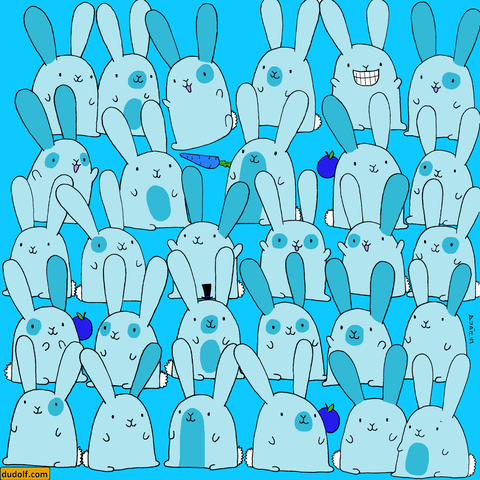

In [ ]:
# Đọc ảnh
image_path = '/content/rabbit2.png'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2_imshow(image_rgb)

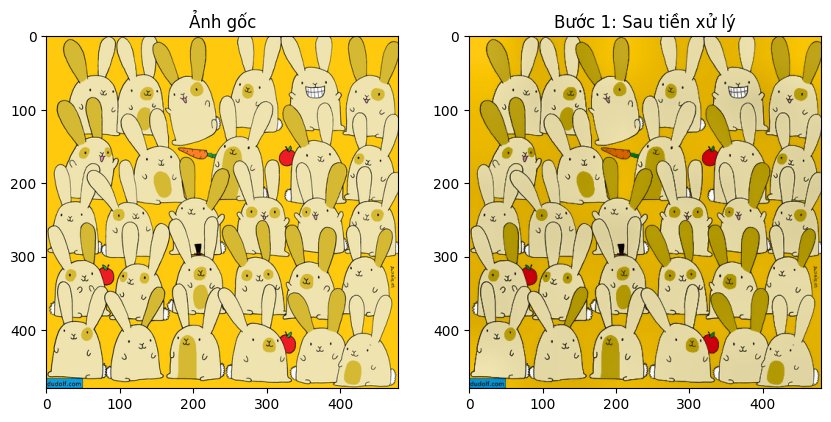

In [ ]:
# 1. Tiền xử lý thích nghi
lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
l = clahe.apply(l)
enhanced_lab = cv2.merge((l, a, b))
enhanced = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

# Lọc để giảm nhiễu nhưng vẫn giữ cạnh
bilateral = cv2.bilateralFilter(enhanced, 9, 75, 75)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title('Ảnh gốc')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(bilateral, cv2.COLOR_BGR2RGB))
plt.title('Bước 1: Sau tiền xử lý')
plt.show()

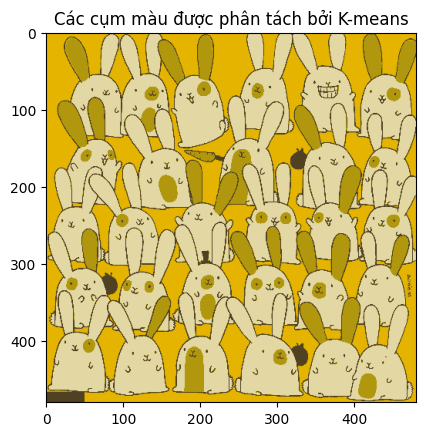

In [ ]:
# 2. Phân cụm với K-means Clustering
flat_image = bilateral.reshape((-1, 3))
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(flat_image)
labels = kmeans.labels_
segments = labels.reshape(image.shape[:2])
cluster_centers = kmeans.cluster_centers_

# Tạo ảnh hiển thị các cụm
clustered_image = np.zeros_like(image_rgb)
for i in range(num_clusters):
    mask = (segments == i)
    # Gán màu trung tâm của cụm cho các pixel thuộc cụm
    clustered_image[mask] = cluster_centers[i].astype(int)[::-1] # Đảo ngược về RGB

plt.imshow(clustered_image)
plt.title('Các cụm màu được phân tách bởi K-means')
plt.show()


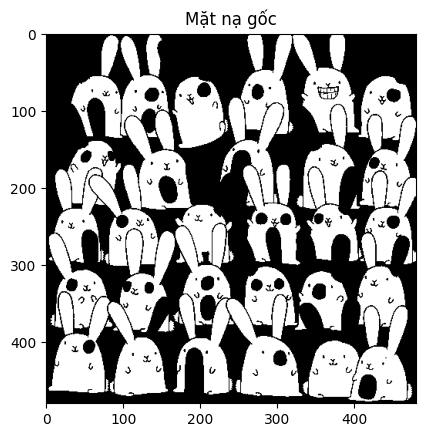

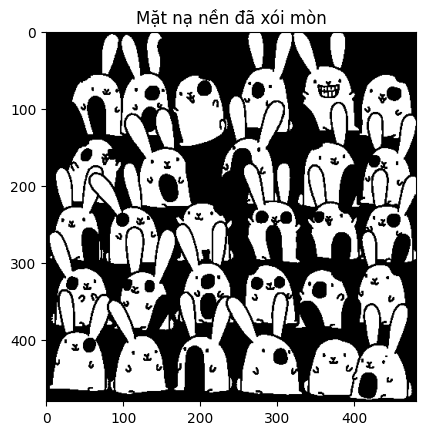

In [ ]:
# 3. Thu nhỏ mặt nạ thỏ (sử dụng xói mòn erosion)
# Tạo mặt nạ cho thỏ
bunny_color = np.array([240, 230, 180])  # Màu be/vàng nhạt (RGB)

bunny_cluster_idx = None
min_dist = float('inf')
for i, center in enumerate(cluster_centers):
    dist = np.linalg.norm(center - bunny_color[::-1])  # BGR sang RGB
    if dist < min_dist:
        min_dist = dist
        bunny_cluster_idx = i

bunny_mask = np.zeros_like(segments, dtype=np.uint8)
bunny_mask[segments == bunny_cluster_idx] = 255

# Tạo kernel cho phép xói mòn
kernel_erosion = np.ones((2, 2), np.uint8)  # Điều chỉnh kích thước kernel

# Áp dụng phép xói mòn lên mặt nạ thỏ
mask_eroded = cv2.erode(bunny_mask, kernel_erosion, iterations=1)

# Hiển thị ảnh
plt.imshow(bunny_mask, cmap='gray')
plt.title('Mặt nạ gốc')
plt.show()
plt.imshow(mask_eroded, cmap='gray')
plt.title('Mặt nạ nền đã xói mòn')
plt.show()


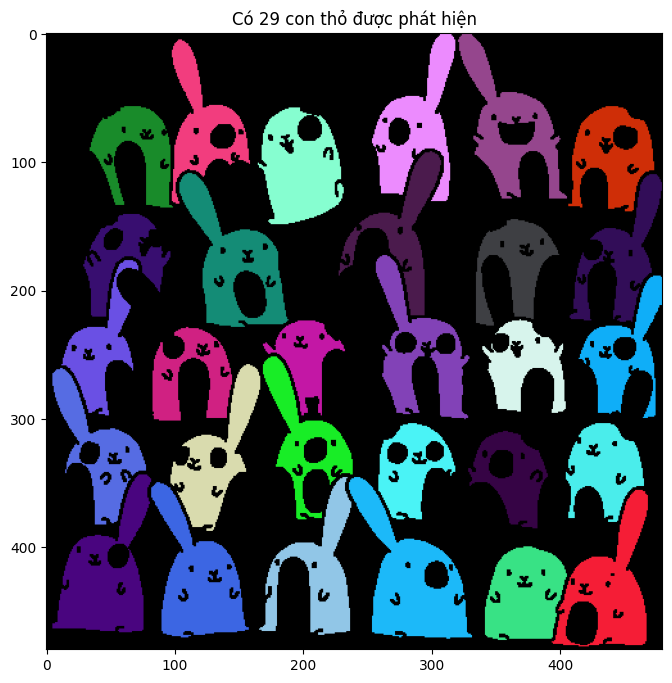

In [ ]:
# 4. Phân tích thành phần liên thông, lọc và gán nhãn màu
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_eroded, connectivity=8)
min_bunny_area = 1000
num_bunnies = 0
labeled_image = np.zeros_like(image_rgb)

for i in range(1, num_labels):
    area = stats[i, cv2.CC_STAT_AREA]
    if area >= min_bunny_area:
        num_bunnies += 1
        mask = (labels == i).astype(np.uint8) * 255
        # Gán màu ngẫu nhiên cho mỗi con thỏ
        color = np.random.randint(0, 255, 3)
        labeled_image[mask > 0] = color

# Hiển thị kết quả
plt.figure(figsize=(10, 8))
plt.imshow(labeled_image)
plt.title(f'Có {num_bunnies} con thỏ được phát hiện')
plt.show()


# Thử nghiệm watershed

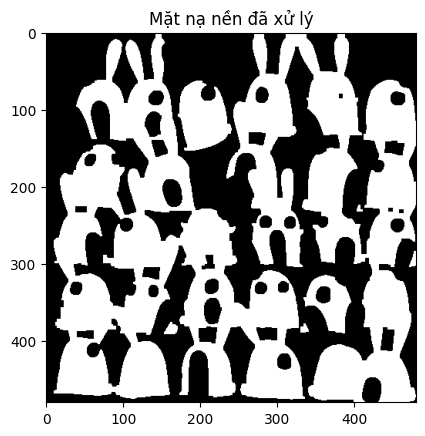

In [ ]:
# 3. Xử lý hình thái học để làm sạch mặt nạ (điều chỉnh)
kernel = np.ones((2, 2), np.uint8)
mask_eroded = cv2.morphologyEx(mask_eroded, cv2.MORPH_CLOSE, kernel)
mask_eroded = cv2.morphologyEx(mask_eroded, cv2.MORPH_OPEN, np.ones((2, 2), np.uint8))

plt.imshow(mask_eroded, cmap='gray')
plt.title('Mặt nạ nền đã xử lý')
plt.show()

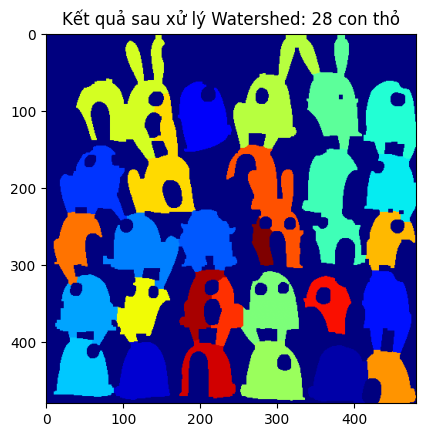

In [ ]:
# 4. Watershed cải tiến để tách thỏ chồng lên nhau (điều chỉnh để giảm số lượng)
# Tính khoảng cách biến đổi
bunny_mask = mask_eroded
dist_transform = cv2.distanceTransform(bunny_mask, cv2.DIST_L2, 5)
local_max = peak_local_max(dist_transform, min_distance=30, labels=bunny_mask, num_peaks=np.inf) # Tăng min_distance

# Initialize markers with the same shape as bunny_mask
markers = np.zeros_like(bunny_mask, dtype=np.int32)

# Assign unique labels to each local maximum
for i, coord in enumerate(local_max):
    markers[coord[0], coord[1]] = i + 1

labels_ws = watershed(-dist_transform, markers, mask=bunny_mask)

# 5. Lọc dựa trên kích thước đối tượng
min_bunny_area = 1000  # Ngưỡng kích thước tối thiểu (điều chỉnh theo ảnh)
filtered_labels_ws = np.zeros_like(labels_ws)
num_bunnies = 0
for label in np.unique(labels_ws):
    if label == 0:
        continue
    mask = (labels_ws == label)
    area = np.sum(mask)
    if area >= min_bunny_area:
        filtered_labels_ws[mask] = num_bunnies + 1
        num_bunnies += 1

# Hiển thị kết quả
plt.imshow(filtered_labels_ws, cmap='jet')
plt.title(f'Kết quả sau xử lý Watershed: {num_bunnies} con thỏ')
plt.show()

watershet trong trường hợp này không tối ưu, có nhiều con thỏ bị tô 2 màu, các con thỏ dính vào nhau